### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.feature_selection import SequentialFeatureSelector
import pickle
from sklearn.preprocessing import PolynomialFeatures,StandardScaler

#Supress Sklearn Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Importing our functions

In [2]:
from functions import compute_metrics,trivial,nearest_means

### Importing the Datasets

In [3]:
train = pd.read_csv('algerian_fires_train.csv')
test = pd.read_csv('algerian_fires_test.csv')

### Trivial Model Performance

              precision    recall  f1-score   support

           0       0.58      0.38      0.46        37
           1       0.36      0.57      0.44        23

    accuracy                           0.45        60
   macro avg       0.47      0.47      0.45        60
weighted avg       0.50      0.45      0.45        60

{'false_negatives': 10, 'accuracy': 0.45, 'precision': 0.36, 'recall': 0.57, 'f1_score': 0.44}


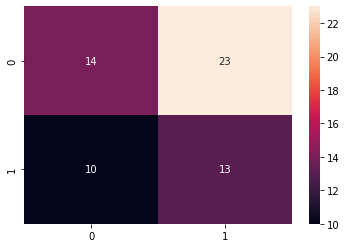

In [4]:
trivial(train,test)

### Baseline Model Performance

Accuracy of Nearest Means on the Test Dataset is 78.33 %
              precision    recall  f1-score   support

           0       0.75      0.97      0.85        37
           1       0.92      0.48      0.63        23

    accuracy                           0.78        60
   macro avg       0.83      0.73      0.74        60
weighted avg       0.81      0.78      0.76        60

{'false_negatives': 12, 'accuracy': 0.78, 'precision': 0.92, 'recall': 0.48, 'f1_score': 0.64}


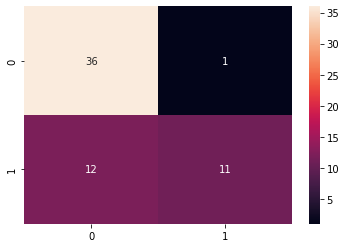

In [5]:
nearest_means(train,test)

### Best Supervised Algorithm Performance

#### Importing the Best Training Model

In [6]:
best_model_params = pickle.load(open('./best_model.pkl','rb'))

#### Preparing the test data for prediction

In [7]:
#Since none of the Avg,Min,Max features were used in the final predictions,we will just create these columns and store zeroes
#We need these columns as standard scaling was done on expanded feature set
test['Avg_Temp'] = 0
test['Min_Temp'] = 0
test['Max_Temp'] = 0
test['Avg_RH'] = 0
test['Min_RH'] = 0
test['Max_RH'] = 0
test['Avg_Ws'] = 0
test['Min_Ws'] = 0
test['Max_Ws'] = 0
test['Avg_Rain'] = 0
test['Min_Rain'] = 0
test['Max_Rain'] = 0
test['Date'] = 0
test['Day of Week'] = 0
test['Weekday/Weekend'] = 0


#Creating the polynomial expanded features
poly_columns = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']
poly = PolynomialFeatures(2)
expanded_test = poly.fit_transform(test[poly_columns])
feature_names = poly.get_feature_names_out(input_features=None)
expanded_test = pd.DataFrame(expanded_test, columns=feature_names)
expanded_test = expanded_test.drop(columns=['1'])
test.reset_index(inplace=True)

#Adding the new columns
expanded_test.insert(1, "Avg_Temp", test['Avg_Temp'])
expanded_test.insert(2, "Min_Temp", test['Min_Temp'])
expanded_test.insert(3, "Max_Temp", test['Max_Temp'])
expanded_test.insert(5, "Avg_RH", test['Avg_RH'])
expanded_test.insert(6, "Min_RH", test['Min_RH'])
expanded_test.insert(7, "Max_RH", test['Max_RH'])
expanded_test.insert(9, "Avg_Ws", test['Avg_Ws'])
expanded_test.insert(10, "Min_Ws", test['Min_Ws'])
expanded_test.insert(11, "Max_Ws", test['Max_Ws'])
expanded_test.insert(12, "Avg_Rain", test['Avg_Rain'])
expanded_test.insert(13, "Min_Rain", test['Min_Rain'])
expanded_test.insert(14, "Max_Rain", test['Max_Rain'])
expanded_test.insert(0, "Weekday/Weekend", test['Weekday/Weekend'])

#Getting the columns
columns = []
for column in expanded_test.columns:
    columns.append(column)

#Standardization
scaler = best_model_params['scaler']
expanded_test.loc[:, expanded_test.columns != 'Classes'] = scaler.transform(expanded_test.loc[:, expanded_test.columns != 'Classes'])
expanded_test = pd.DataFrame(expanded_test, columns=columns)

# #Taking only those columns which were selected using SFS on train dataset
expanded_test = expanded_test[best_model_params['columns']]

#### Predicting the test set

Accuracy on test set with best Supervised Model (KNN) is: 86.66666666666667%
f1score on test set with best Supervised Model (KNN) is: 0.8181818181818182


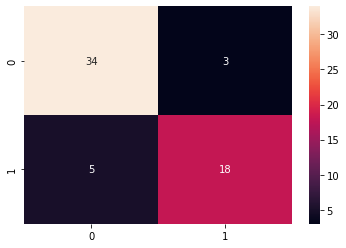

In [10]:
model = best_model_params['model']
Y_pred = model.predict(expanded_test)
model_score=accuracy_score(test[['Classes']],Y_pred)
model_f1score = f1_score(test[['Classes']],Y_pred)
sns.heatmap(confusion_matrix(test[['Classes']],Y_pred),annot=True)
print(f'Accuracy on test set with best Supervised Model (KNN) is: {model_score*100}%')
print(f'f1score on test set with best Supervised Model (KNN) is: {model_f1score}')